In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
df = pd.read_excel('DatosCacao_multivariado.xlsx')
df = df.fillna(method='ffill').dropna()
print(df.head())

       Fecha   COP/kg      TRM  COP/kg (internacional)   Produccion
1 2024-01-08  14223.3  3912.93                16092.12  4682.314840
2 2024-01-15  14086.3  3901.38                17102.48  4682.314840
3 2024-01-22  14329.2  3916.39                17909.81  4682.314840
4 2024-01-29  14530.8  3925.26                18449.86  4682.314840
5 2024-02-05  14765.8  3928.11                20111.73  5485.172646


C:\Users\peter\AppData\Local\Temp\ipykernel_19204\953973482.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').dropna()


In [3]:
# 2. Escalar datos para mejorar la convergencia de la red
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df.drop(columns=['Fecha']))

# 3. Función para crear secuencias de ventana (timesteps)
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps, :])  # ventana completa con variables (incluyendo exógenas)
        y.append(data[i+n_steps, 0])   # precio objetivo (col 0)
    return np.array(X), np.array(y)

timesteps = 10  # ventanas de semanas
X, y = create_sequences(data_scaled, timesteps)

# 4. Dividir 80/20 para entrenamiento y prueba
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [4]:
# 5. Construir modelo LSTM simple
model = Sequential()
model.add(LSTM(units=128, activation='relu', input_shape=(timesteps, X.shape[2])))
model.add(Dense(1))  # salida única
model.compile(optimizer='adam', loss='mse')

# 6. Entrenar modelo
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 594ms/step - loss: 0.3759 - val_loss: 0.1700
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.2650 - val_loss: 0.0910
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.1648 - val_loss: 0.0300
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0828 - val_loss: 0.0103
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0548 - val_loss: 0.0526
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0818 - val_loss: 0.0657
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0780 - val_loss: 0.0385
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0534 - val_loss: 0.0175
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0425 - val_loss: 0.0092
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0405 - val_loss: 0.0079
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0427 - val_loss: 0.0082
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0439 - val_loss: 0.0083


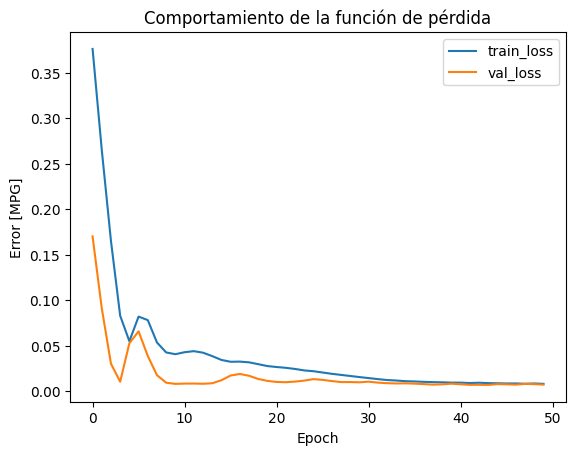

In [5]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')

plt.title("Comportamiento de la función de pérdida")
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.legend()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
RMSE en test (original scale): 1884.83


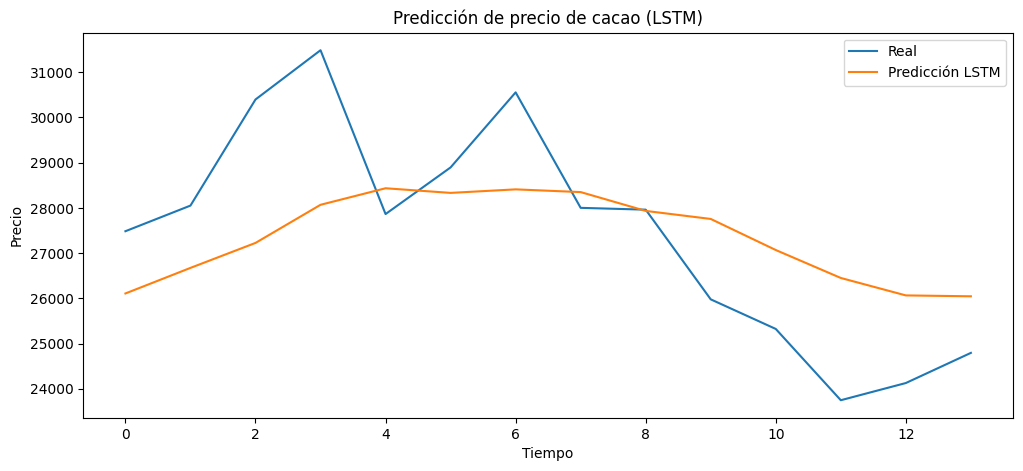

In [6]:
# 7. Predecir y rescatar datos escala original
y_pred = model.predict(X_test)
y_test_rescaled = scaler.inverse_transform(np.hstack([y_test.reshape(-1,1), X_test[:,0,1:]]))[:,0]
y_pred_rescaled = scaler.inverse_transform(np.hstack([y_pred, X_test[:,0,1:]]))[:,0]

# 8. Calcular RMSE en escala original
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f'RMSE en test (original scale): {rmse:.2f}')

# 9. Graficar
plt.figure(figsize=(12,5))
plt.plot(y_test_rescaled, label='Real')
plt.plot(y_pred_rescaled, label='Predicción LSTM')
plt.legend()
plt.title('Predicción de precio de cacao (LSTM)')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


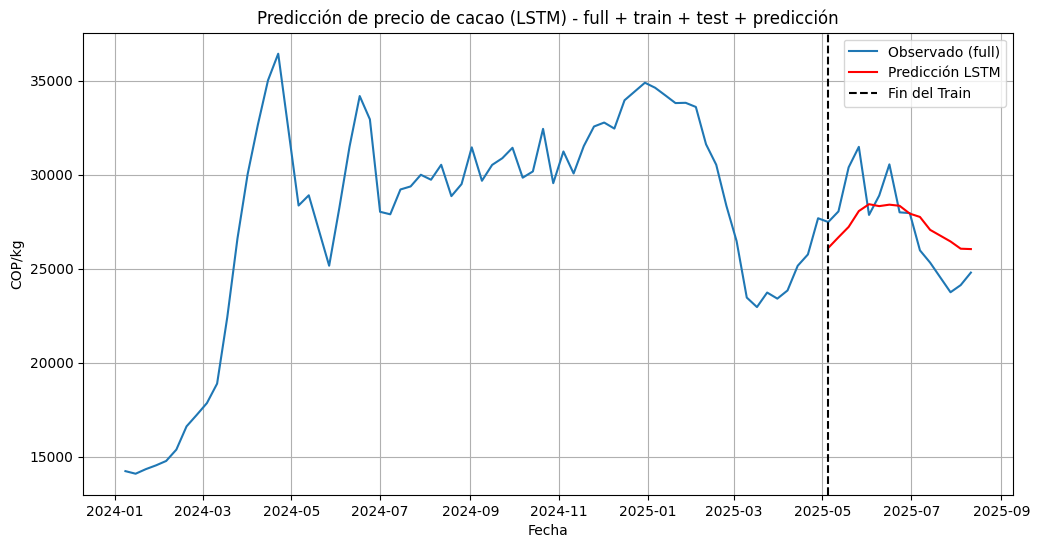

In [7]:
dates = df['Fecha']

# predecir
y_pred = model.predict(X_test)

# reconstruir para inverse_transform: usar las exógenas del último timestep de cada ventana
exog_last_test = X_test[:, -1, 1:]  # shape (n_test, n_exog)
to_inv_pred = np.hstack([y_pred.reshape(-1,1), exog_last_test])
to_inv_true = np.hstack([y_test.reshape(-1,1), exog_last_test])

# invertir escala y extraer la primera columna (objetivo en escala original)
y_pred_rescaled = scaler.inverse_transform(to_inv_pred)[:,0]
y_test_rescaled = scaler.inverse_transform(to_inv_true)[:,0]

# índices de las filas objetivo en el df original:
# para cada secuencia i -> target en fila i + timesteps
n_sequences = X.shape[0]
train_count = split           # número de secuencias usadas en train
# targets de train: timesteps .. timesteps+train_count-1
train_target_idx = np.arange(timesteps, timesteps + train_count)
# targets de test: timesteps+train_count .. timesteps+train_count+len(y_test)-1
test_target_start = timesteps + train_count
test_target_idx = np.arange(test_target_start, test_target_start + len(y_test))

# fechas correspondientes
train_dates = dates.iloc[train_target_idx].reset_index(drop=True)
test_dates = dates.iloc[test_target_idx].reset_index(drop=True)

# (opcional) reconstruir y_train en escala original para graficar train
exog_last_train = X_train[:, -1, 1:]
to_inv_train = np.hstack([y_train.reshape(-1,1), exog_last_train])
y_train_rescaled = scaler.inverse_transform(to_inv_train)[:,0]

# Graficar: serie completa + train + test + predicción
plt.figure(figsize=(12,6))
plt.plot(dates, df["COP/kg"], label='Observado (full)', color='C0')

# test reales y predicción alineadas en las mismas fechas
plt.plot(test_dates, y_pred_rescaled, label='Predicción LSTM', color='red')

# línea vertical que marca fin del train (última fecha objetivo usada en train)
plt.axvline(test_dates.iloc[0], color='k', linestyle='--', label='Fin del Train')

plt.legend()
plt.title('Predicción de precio de cacao (LSTM) - full + train + test + predicción')
plt.xlabel('Fecha')
plt.ylabel('COP/kg')
plt.grid(True)
plt.show()
# ...existing code...